## Линейная регрессия: переобучение и регуляризация

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [6]:
df = pd.read_csv('bikes_rent.csv', header = 0)
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.181250,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.686950,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.470250,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.606100,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.463500,43.6957,12.522300,5.597810,1600
5,1,0,1,0,4,1,1,8.378268,11.660450,51.8261,6.000868,2.682552,1606
6,1,0,1,0,5,1,2,8.057402,10.441950,49.8696,11.304642,5.053483,1510
7,1,0,1,0,6,0,2,6.765000,8.112700,53.5833,17.875868,7.991000,959
8,1,0,1,0,0,0,1,5.671653,5.808750,43.4167,24.250650,10.840702,822
9,1,0,1,0,1,1,1,6.184153,7.544400,48.2917,14.958889,6.687031,1321


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


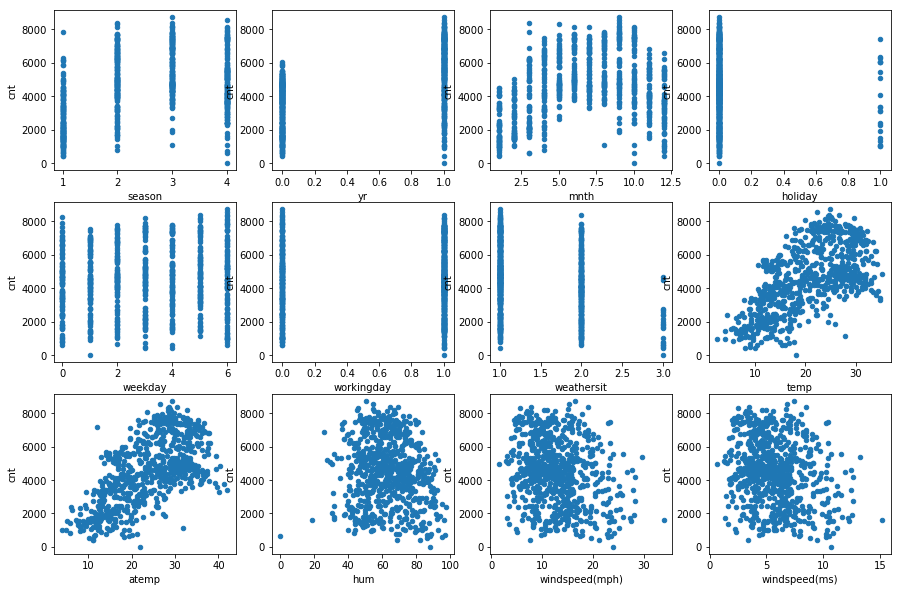

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

for idx, feature in enumerate(df.columns[:-1]):
    #print(idx, feature)
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Задание 1 (0.5 балла):__
Укажите один или два признака, от которых число прокатов скорее всего зависит линейно.
   * ответ: 1. От температуры по ощущениям в Цельсиях(atemp);  2. От температуры в Цельсиях (temp)

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [19]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

focus_cols = ['cnt']
df.drop(focus_cols, axis = 1).corr()



,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [22]:
df.drop(focus_cols, axis = 1).corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [26]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:

focus_cols = 'cnt'
columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

df[columns].corr()


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [7]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков

df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [27]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [28]:
df_shuffled = shuffle(df, random_state=123)
x = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [29]:
from sklearn.linear_model import LinearRegression 

In [83]:
# Код 2.1 (0.5 балла)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

skm = LinearRegression()
skm.fit(x, y)
columns = df.columns[:12]
predictions = skm.predict(x)

list(zip(columns, skm.coef_))



[('season', 570.87166018881931),
 ('yr', 1021.9681141542968),
 ('mnth', -141.30471071341395),
 ('holiday', -86.756216845717375),
 ('weekday', 137.22340368157441),
 ('workingday', 56.393735828395506),
 ('weathersit', -330.2317081049294),
 ('temp', 367.47305679011254),
 ('atemp', 585.55786521602681),
 ('hum', -145.60737566070202),
 ('windspeed(mph)', 12457919068698.219),
 ('windspeed(ms)', -12457919068896.668)]

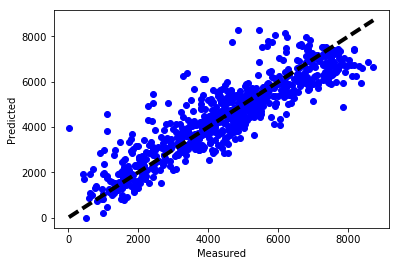

In [86]:
fig, ax = plt.subplots()
ax.scatter(y, predictions, color = 'blue')
ax.plot( [y.min(), y.max()],[y.min(), y.max()], 'k--', linewidth = 4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [87]:
from sklearn.linear_model import Lasso, Ridge

In [93]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса

rid = Ridge()
rid.fit (x, y) 
#Ridge(alpha=0.5, copy_X = True, fit_intercept = True, max_iter = None,
      #normalize = False, random_state = None, solver='auto', tol = 0.001)

list(zip(columns, rid.coef_))

[('season', 563.06457225201257),
 ('yr', 1018.9483787875281),
 ('mnth', -131.87332028247269),
 ('holiday', -86.746097997092548),
 ('weekday', 138.00511117871898),
 ('workingday', 55.903110375064493),
 ('weathersit', -332.34978849907299),
 ('temp', 386.45788919194382),
 ('atemp', 566.3470470600322),
 ('hum', -145.0713272986724),
 ('windspeed(mph)', -99.25944108184116),
 ('windspeed(ms)', -99.259441154292418)]

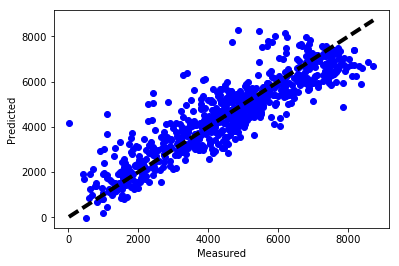

In [90]:
ridge_predictions = rid.predict(x)
fig, ax = plt.subplots()
ax.scatter(y, ridge_predictions, color = 'blue')
ax.plot( [y.min(), y.max()],[y.min(), y.max()], 'k--', linewidth = 4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

In [92]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

las = Lasso()
las.fit(x, y)
#Lasso(alpha = 0.1, copy_X = True, fit_intercept = True, max_iter = 1000,
  #normalize = False, positive = False, precompute = False, random_state = None,
#selection = 'cyclic', tol = 0.0001, warm_start = False)

list(zip(columns, las.coef_))

[('season', 560.2416160308868),
 ('yr', 1019.4634940657199),
 ('mnth', -128.73062703678758),
 ('holiday', -86.152781333711047),
 ('weekday', 137.34789390496303),
 ('workingday', 55.21237064135682),
 ('weathersit', -332.36985696234876),
 ('temp', 376.3632362096975),
 ('atemp', 576.53079350455221),
 ('hum', -144.12915500348589),
 ('windspeed(mph)', -197.13968940248512),
 ('windspeed(ms)', -2.8050416772134453e-08)]

### Проблема вторая: неинформативные признаки

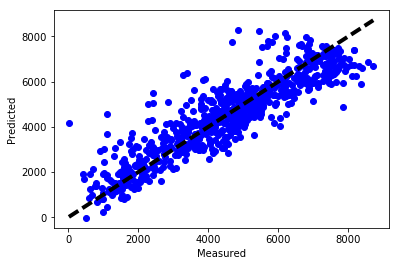

In [94]:
lasso_predictions = las.predict(x)
fig, ax = plt.subplots()
ax.scatter(y, lasso_predictions, color = 'blue')
ax.plot( [y.min(), y.max()],[y.min(), y.max()], 'k--', linewidth = 4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках.
Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

In [95]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], x.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], x.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for alphas_num, alphas in enumerate(alphas):
    lass = Lasso(alpha = alphas)
    lass.fit(x, y)
    coefs_lasso[alphas_num] = lass.coef_

alphas = np.arange(1, 500, 50)

for alphas_num, alphas in enumerate(alphas):
    ridd = Ridge(alpha = alphas)
    ridd.fit(x, y)
    coefs_ridge[alphas_num] = ridd.coef_

print('coefs_lasso:', '\n', coefs_lasso, '\n')
print('coefs_ridge:', '\n', coefs_ridge)

coefs_lasso: 
 [[  5.60241616e+02   1.01946349e+03  -1.28730627e+02  -8.61527813e+01
    1.37347894e+02   5.52123706e+01  -3.32369857e+02   3.76363236e+02
    5.76530794e+02  -1.44129155e+02  -1.97139689e+02  -2.80504168e-08]
 [  4.10969632e+02   9.77019409e+02  -0.00000000e+00  -5.34489688e+01
    9.19434374e+01   1.75372118e+01  -3.18125568e+02   3.22829934e+02
    6.10031512e+02  -9.10689615e+01  -1.45066095e+02  -2.29877063e-08]
 [  3.70077089e+02   9.35945490e+02   0.00000000e+00  -1.21619360e+01
    4.88886342e+01   0.00000000e+00  -3.08805664e+02   2.69417263e+02
    6.32502623e+02  -2.75042876e+01  -9.37749037e+01  -2.41652170e-08]
 [  3.32835717e+02   8.91870058e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.79616688e+02   2.11052030e+02
    6.62920880e+02  -0.00000000e+00  -5.01551472e+01  -2.62761604e-08]
 [  2.98134448e+02   8.45652857e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.35571345e+02   1.24144807e+02
 

Визуализируем динамику весов при увеличении параметра регуляризации:

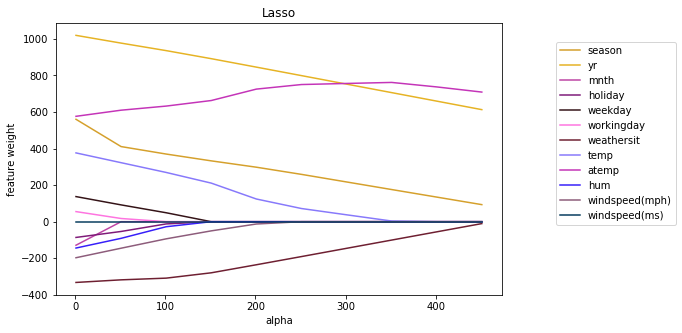

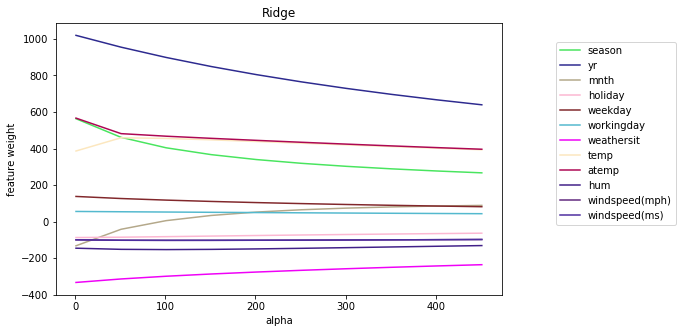

In [96]:
alphas = np.arange(1, 500, 50)
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
    
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [97]:
from sklearn.linear_model import LassoCV

In [121]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

lasso_CV = LassoCV(cv = 3, alphas = alphas)
lasso_CV.fit(x, y)
MSE = lasso_CV.mse_path_
avg_MSE = []

for mse_num in range(len(MSE)):
    avg_MSE.append((MSE[mse_num].mean()))

alpha_ = lasso_CV.alpha_
print('Chosen alpha_ is ', alpha_)  #выбранное значение параметра регуляризации

list(zip(df.columns, lasso_CV.coef_))

Chosen alpha_ is  6


[('season', 532.01898284135359),
 ('yr', 1015.0602226430593),
 ('mnth', -100.03952614356638),
 ('holiday', -83.293959875299095),
 ('weekday', 132.50446549095807),
 ('workingday', 51.557085614073848),
 ('weathersit', -330.55985673998123),
 ('temp', 370.67985503003598),
 ('atemp', 581.39693106549589),
 ('hum', -140.00740550068895),
 ('windspeed(mph)', -191.77140847135107),
 ('windspeed(ms)', -2.6854208375775755e-08)]

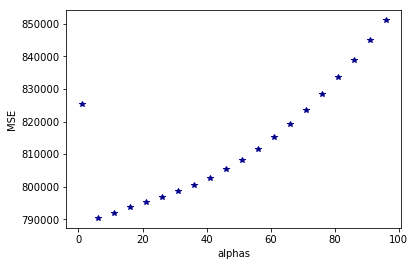

In [120]:
plt.plot(lasso_CV.alphas_, avg_MSE,'b*', color = 'darkblue')
plt.ylabel("MSE")
plt.xlabel("alphas")
plt.show()

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

    alpha            cv1
11     41  843336.181499
    alpha            cv2
18      6  772598.495628
    alpha            cv3
19      1  745668.605961


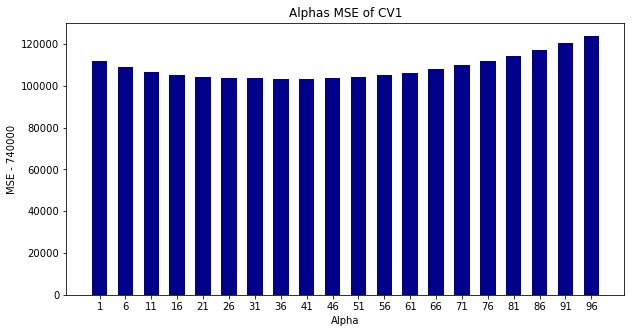

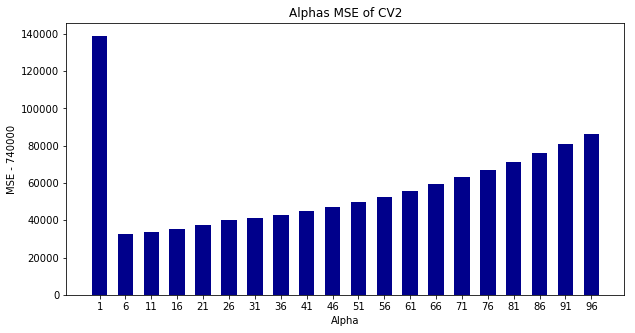

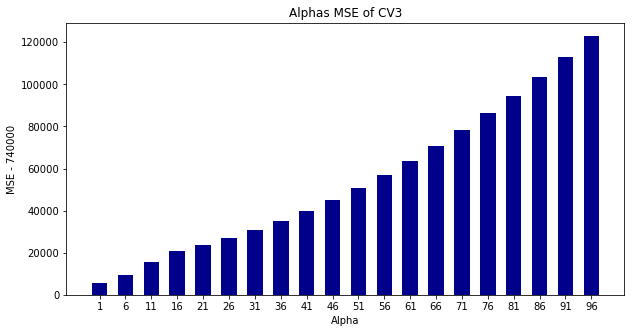

,alpha,cv1,cv2,cv3
0,96,863936.509812,826364.119369,862993.297519
1,91,860479.315114,821110.181778,853075.137806
2,86,857344.836061,816153.277824,843628.812861
3,81,854526.736394,811496.348057,834654.453573
4,76,852024.623414,807139.396572,826152.163990
5,71,849838.187554,803082.423385,818122.019349
6,66,847967.162328,799325.428498,810564.074047
7,61,846411.318128,795868.411909,803478.367415
8,56,845170.457080,792711.373619,796864.927886
9,51,844244.408617,789854.313627,790723.776016


In [122]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

cvdf = pd.DataFrame({'alpha' : lasso_CV.alphas_, 
                   'cv1' : MSE[:, 0], 
                   'cv2' : MSE[:, 1], 
                   'cv3' : MSE[:, 2]})
for i in range(1, 4):
    cv = 'cv' + str(i)
    print(cvdf[['alpha', cv]].loc[cvdf[cv] == cvdf[cv].min()])

norm = 74*10**4
for i in range(0, MSE.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.bar(lasso_CV.alphas_, MSE[:, i] - norm, color = 'darkblue', width = 3)
    plt.title("Alphas MSE of CV" + str(i+1))
    plt.xlabel("Alpha")
    plt.xticks(alphas)
    plt.ylabel("MSE - " + str(norm))
    plt.show()
    
cvdf

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Задание 2. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * **Ответ:**  1. Видна только на графиках temp и atemp. 
    2. Нет, это не относится к yr и season.

In [132]:
import operator
sorted_z = sorted(dict(zip(df.columns, lasso_CV.coef_)).items(), key=operator.itemgetter(1))
sorted_z.reverse()
df1 = pd.DataFrame(sorted_z[:4])
df1

,0,1
0,yr,1015.060223
1,atemp,581.396931
2,season,532.018983
3,temp,370.679855


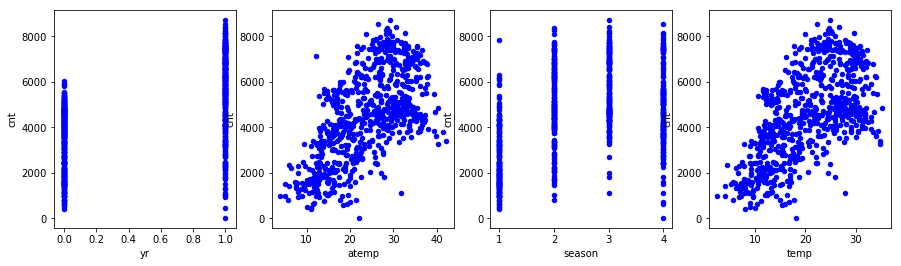

In [218]:
rows_count = df1[0].count()

fig, axes = plt.subplots(nrows=1, ncols=rows_count, figsize=(15, 4))
for idx, feature in enumerate(df1[0]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx % rows_count], color='blue')
    

2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * **Ответ:**   Да, наблюдается линейная зависимость. 

In [128]:
df2 = pd.DataFrame(sorted_z[:3])
df2

,0,1
0,weathersit,-330.559857
1,windspeed(mph),-191.771408
2,hum,-140.007406


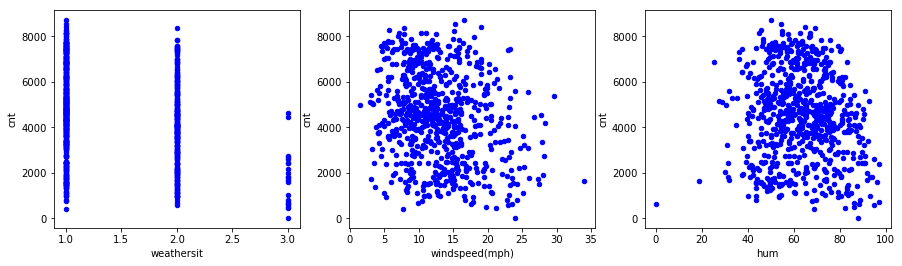

In [217]:
rows_count = df2[0].count()

fig, axes = plt.subplots(nrows=1, ncols=rows_count, figsize=(15, 4))
for idx, feature in enumerate(df2[0]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx % rows_count], color='blue')

3. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * **Ответ:** Влияют. Чем больше скорость, тем меньше прокатов. 

In [196]:
df3 = pd.DataFrame(sorted_z[6:7])
df3

,0,1
0,windspeed(ms),-2.685421e-08


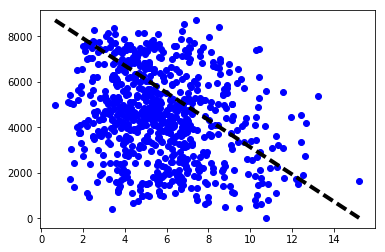

In [216]:
# df.plot("windspeed(ms)", "cnt", kind="scatter")
# plt.show()

fig, ax = plt.subplots()
ax.scatter(df['windspeed(ms)'], df['cnt'], color = 'blue')
ax.plot([df['windspeed(ms)'].min(), df['windspeed(ms)'].max()], [df['cnt'].max(), df['cnt'].min()], 'k--', linewidth = 4)
plt.show()

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.